In [1]:
import os
import socket

In [2]:
def get_hostname():
        
    print("Available devices:")
    hostname = socket.gethostname()
    return hostname

In [3]:
skip_if_set_local_env_done=True

if get_hostname() == "xscape7x" and skip_if_set_local_env_done is False:

    print("🔄 Snapdragon X Elite detected - optimizing for CPU")

    # Use environment variables instead (set before TF init)
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'
    os.environ['OMP_NUM_THREADS'] = '8'
    os.environ['TF_NUM_INTEROP_THREADS'] = '8'
    os.environ['TF_NUM_INTRAOP_THREADS'] = '8'
    # Restart Python kernel after setting these
    print("✅ Environment configured - restart kernel for full effect")

Available devices:


In [4]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

#print(tf.config.list_physical_devices())

gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs found: {len(gpus)}")
for gpu in gpus:
    print(f" {gpu}")
if tf.config.list_physical_devices('GPU'):
    mixed_precision.set_global_policy('mixed_float16')
else:
    mixed_precision.set_global_policy('float32')


GPUs found: 0


In [5]:
import sys
import numpy as np
import pandas as pd
# At the top of your notebook

import matplotlib.pyplot as plt

import cv2
from pathlib import Path
from datetime import datetime
import math

import seaborn as sns
import json

import socket

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Flatten, Dropout, Dense, Input, GlobalAveragePooling2D, Conv2D,
    BatchNormalization, Activation, MaxPooling2D, Lambda
)
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
)
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight


try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except NameError:
    pass

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


In [6]:
import keras

print("TF version:", tf.__version__)
print("Keras version:", keras.__version__)

TF version: 2.19.1
Keras version: 3.11.2


In [7]:
# =========================================================================
# Data Loading Utilities
# =========================================================================
def is_on_kaggle():
    """Detect if running on Kaggle."""
    return os.path.exists('/kaggle/input')

def get_data_path():
    """Detect environment and return appropriate data path."""
    if is_on_kaggle():
        print("🌐 Running on Kaggle")
        import kagglehub
        image_path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")
        folder_path = os.path.join(image_path, "images")
    else:
        print("💻 Running on local machine")
        folder_path = "data/images/"
    
    return folder_path

In [8]:

# =========================================================================
# Model Building
# =========================================================================

def build_custom_cnn(config):
    """Build custom CNN model"""
    picture_size = config.get('picture_size')
    color_mode = config.get('color_mode')
    channels = 1 if color_mode == 'grayscale' else 3
    input_shape=(picture_size,picture_size,channels)
    dropout_rate = config.get('dropout_rate')
    
    model = tf.keras.models.Sequential()
   # Block 1 - Double Conv
    model.add(Conv2D(filters=64, 
                        kernel_size=(3, 3), 
                        padding='same', 
                        input_shape=input_shape,
                        name='conv2d_1'))
    model.add(BatchNormalization(name='bn_1'))
    model.add(Activation('relu', name='relu_1'))
    model.add(MaxPooling2D((2, 2), name='maxpool2d_1'))
    model.add(Dropout(dropout_rate * 0.5, name='dropout_1'))

    # Block 2 - Double Conv
    model.add(Conv2D(filters=64, 
                      kernel_size=(3, 3), 
                      padding='same',
                      name='conv2d_2'))
    model.add(BatchNormalization(name='bn_2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_2'))
    model.add(Dropout(dropout_rate *0.75,name='dropout_2'))
    
    # Block 3 - Double Conv
    model.add(Conv2D(filters=128, 
                      kernel_size=(3, 3), 
                      padding='same',
                      name='conv2d_3'))
    model.add(BatchNormalization(name='bn_3'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_3'))
    model.add(Dropout(dropout_rate,name='dropout_3'))
    
    # Block 4 - Double Conv
    model.add(Conv2D(filters=512, 
                      kernel_size=(3, 3), 
                      padding='same',
                      name='conv2d_4',
                      kernel_regularizer=regularizers.l2(0.01)
                      ))
    model.add(BatchNormalization(name='bn_4'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_4'))
    model.add(Dropout(dropout_rate,name='dropout_4'))

    """
    # Block 5 - Double Conv
    model.add(Conv2D(filters=512, 
                      kernel_size=(3, 3), 
                      padding='same',
                      name='conv2d_5',
                      kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization(name='bn_5'))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_5'))
    model.add(Dropout(dropout_rate,name='dropout_5'))
    """
        
    model.add(Flatten())
    
    # Add dense layers
    for i, units in enumerate(config.get('dense_units', [512])):
        model.add(Dense(units, activation='relu', name=f'dense_{i}'))
        model.add(BatchNormalization(name=f'bn_dense_{i}'))
        model.add(Dropout(config.get('dropout_rate'), name=f'dropout_dense_{i}'))

    # Output layer (outside the loop)
    model.add(Dense(config.get('no_of_classes'),
                activation='softmax',
                dtype='float32',
                name='output'))
    
    return model, None

In [9]:
def build_transfer_model(config, backbone_class):
    """Build transfer learning model for MobileNetV2 / EfficientNetB0."""
    picture_size = config.get('picture_size')
    color_mode = config.get('color_mode')

    # Determine if this is EfficientNet
    is_efficientnet = backbone_class is EfficientNetB0
    

    # EfficientNetB0 expects 224x224 RGB
    if is_efficientnet:
        backbone_input_size = 224
        backbone_channels = 3
    else:
        backbone_input_size = picture_size
        backbone_channels = 3  # we’ll convert grayscale to RGB if needed

    # Our model input
    channels = 1 if (color_mode == 'grayscale' and not is_efficientnet) else 3
    inputs = Input(shape=(backbone_input_size, backbone_input_size, channels))

    # Convert grayscale to RGB for non-EfficientNet cases only
    if channels == 1:
        x = Lambda(lambda z: tf.image.grayscale_to_rgb(z))(inputs)
    else:
        x = inputs

    # Backbone always sees RGB (3 channels)
    base_model = backbone_class(
        weights='imagenet',
        include_top=False,
        input_shape=(backbone_input_size, backbone_input_size, 3),
    )
    base_model.trainable = False

    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(config.get('dropout_rate'))(x)

    for units in config.get('dense_units', [512]):
        x = Dense(units, activation='relu')(x)
        x = Dropout(config.get('dropout_rate'))(x)

    outputs = Dense(
        config.get('no_of_classes'),
        activation='softmax',
        dtype='float32'
    )(x)

    model = Model(inputs, outputs)
    return model, base_model

In [10]:

def build_model(config):
    """Build model based on configuration"""
    backbone = config.backbone
    
    if backbone == 'custom_cnn':
        return build_custom_cnn(config)
    elif backbone == 'mobilenet':
        return build_transfer_model(config, MobileNetV2)
    elif backbone == 'efficientnet':
        return build_transfer_model(config, EfficientNetB0)
    else:
        raise ValueError(f"Unknown backbone: {backbone}")


In [11]:

# =========================================================================
# Training Utilities
# =========================================================================

def create_callbacks(config):
    """Create training callbacks"""
    callbacks = [
        ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_delta=0.0001)
    ]
    
    if config.get('use_lr_schedule'):
        def cosine_annealing(epoch, lr):
            initial_lr = float(config.get('learning_rate'))
            min_lr = 1e-7
            warmup = 10
            total_epochs = config.get('epochs')
            
            if epoch < warmup:
                return initial_lr * (epoch + 1) / warmup
            
            progress = (epoch - warmup) / (total_epochs - warmup)
            lr_out = min_lr + (initial_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
            return max(lr_out, min_lr)
        
        callbacks.append(LearningRateScheduler(cosine_annealing))
    
    return callbacks

def compute_class_weights(train_set):
    """Compute class weights for imbalanced data"""
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_set.classes),
        y=train_set.classes
    )
    return dict(enumerate(class_weights))


<h1> Run Training </h1>

In [12]:
def create_output_dir():
    # - create output folder and provide output path
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    if os.path.exists('/kaggle/working'):
        output_dir = "/kaggle/working/" + timestamp + "/"  
    else:
        output_dir = "outputs/" + timestamp + "/"

    os.makedirs(output_dir, exist_ok=True)

    print (f"Output directory: {output_dir}")
    return output_dir, timestamp

In [13]:
def save_model(model, model_name_prefix, output_dir, folder_name):
    # timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = f"{model_name_prefix}_{folder_name}.keras"
    out_path = Path(output_dir) / model_name
    try:
        model.save(str(out_path))
        print(f"\n💾 Model saved: {out_path}")
    except Exception as e:
        print(f"Error saving model: {e}")
    
    return out_path

<h1>Load Model and Generate Reports</h1>

In [14]:

def load_model_path():
    import os,re, glob
    from pathlib import Path
    from datetime import datetime
    
     # ensure these are always defined
    latest_ft = None
    latest_dir = None

    # Detect environment and set base directory
    if os.path.exists('/kaggle/working'):
        base_dir = "/kaggle/working"
        print("🌐 Running on Kaggle - searching in /kaggle/working")
    else:
        base_dir="outputs"
        print("💻 Running locally - searching in outputs/")
    
    # Find all valid .keras files
    search_pattern = os.path.join(base_dir, "*/*.keras")
    valid_files = [
        f for f in glob.glob(search_pattern)
            if re.match(r'^\d{8}_\d{6}$', os.path.basename(os.path.dirname(f)))
            ]

    if not valid_files:
        print(f"❌ No valid .keras files found in {base_dir}")
        
    else:
        # Find latest timestamp
        latest = max(valid_files, key=lambda x: datetime.strptime(
            os.path.basename(os.path.dirname(x)), "%Y%m%d_%H%M%S"
        ))
        latest_dir = os.path.dirname(latest)

        # Look for ft variants in the same latest directory
        ft_pattern = os.path.join(latest_dir, "*_ft_*.keras")
        ft_files = glob.glob(ft_pattern)
        
        latest_ft = ft_files[0] if ft_files else None

        print(f"Latest directory: {latest_dir}")
        print(f"Latest FT model: {latest_ft}")
    
    return latest_ft, latest_dir

In [15]:
def load_models_from_file(path_ft):
    from tensorflow.keras.models import load_model
    
    model=load_model(path_ft)

    return model


In [16]:
def plot_training_history(history_ft):
    """
    Plot training history.
    - If only history_hd exists: plot that.
    - If only history_ft exists: plot that.
    - If both exist: concatenate them (head + fine‑tune).
    """
    # Helper to safely get metric arrays
    def get_vals(h, key):
        return h.history.get(key, []) if h is not None else []

    # Concatenate if both present
    train_acc  = get_vals(history_ft, 'accuracy')
    val_acc    = get_vals(history_ft, 'val_accuracy')
    train_loss = get_vals(history_ft, 'loss')
    val_loss   = get_vals(history_ft, 'val_loss')

    if not any([train_acc, val_acc, train_loss, val_loss]):
        print("⚠️ No training metrics available to plot")
        return None

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    if train_acc:
        axes[0].plot(train_acc, label='Train Accuracy')
    if val_acc:
        axes[0].plot(val_acc, label='Val Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Loss plot
    if train_loss:
        axes[1].plot(train_loss, label='Train Loss')
    if val_loss:
        axes[1].plot(val_loss, label='Val Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    return fig

In [17]:
def publish_final_evaluation(train_acc, val_acc, train_loss, val_loss):
    # Final evaluation
    print("\n" + "="*70)
    print("📊 FINAL EVALUATION")
    print("="*70)
    print(f"Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"Training Loss:       {train_loss:.4f}")
    print(f"Validation Loss:     {val_loss:.4f}")
    print("="*70)
    
    return


In [18]:

# =======================================================================
# Sample Predictions Visualization
# =======================================================================

def test_random_predictions(model, validation_set, class_labels):

    import random

    # Get a random batch from validation set
    random_batch_idx = random.randint(0, len(validation_set) - 1)
    sample_images, sample_labels = validation_set[random_batch_idx]

    # Predict
    sample_preds = model.predict(sample_images, verbose=0)
    sample_pred_classes = np.argmax(sample_preds, axis=1)
    sample_true_classes = np.argmax(sample_labels, axis=1)

    # Randomly select 16 indices from the batch
    num_samples = min(16, len(sample_images))
    random_indices = random.sample(range(len(sample_images)), num_samples)

    # Visualize predictions
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()

    for i, idx in enumerate(random_indices):
        axes[i].imshow(sample_images[idx].squeeze(), cmap='gray')
        
        true_label = class_labels[sample_true_classes[idx]]
        pred_label = class_labels[sample_pred_classes[idx]]
        confidence = sample_preds[idx][sample_pred_classes[idx]] * 100

        # Color: green if correct, red if wrong
        color = 'green' if sample_true_classes[idx] == sample_pred_classes[idx] else 'red'
        
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)', 
                        color=color, fontweight='bold')
        axes[i].axis('off')

    plt.suptitle('Sample Predictions on Validation Set', fontsize=16, fontweight='bold')
    plt.tight_layout()
    #plt.show()
    return plt

In [19]:


# =========================================================================
# Enhanced Model Evaluation and Reporting
# =========================================================================

class ModelEvaluator:
    """Comprehensive model evaluation and report generation"""
    
    def __init__(self, model, test_set, class_labels, output_dir=None, save_outputs=False):
        self.model = model
        self.test_set = test_set
        self.class_labels = class_labels
        self.output_dir = output_dir
        self.save_outputs=save_outputs
        
 
        
        # Initialize prediction attributes
        self.predictions = None
        self.true_labels = None
        self.pred_labels = None
        
    def save_output(self):
        out_path = Path(self.output_dir) 
        try:
            plt.savefig(os.path.join(out_path,f"{self.fig_name}.png"),dpi=300,bbox_inches='tight')
            print(f"\n💾 Plot saved: {out_path}")
        except Exception as e:
            print(f"Error saving report: {e}")
        return out_path   
        
    def generate_predictions(self):
        """Generate predictions on test set"""
        print("🔄 Generating predictions...")
        self.test_set.reset()
        
        self.predictions = self.model.predict(self.test_set, verbose=1)
        self.true_labels = self.test_set.classes
        self.pred_labels = np.argmax(self.predictions, axis=1)
        
        return self.predictions, self.true_labels
    
    def create_comprehensive_report(self):
        """Generate comprehensive evaluation report"""
        if self.predictions is None:
            self.generate_predictions()
        
          
        # Generate all reports
        self.plot_training_history()
        self.plot_confusion_matrix()
        self.plot_normalized_confusion_matrix()
        self.generate_classification_report()
        self.plot_per_class_metrics()
        self.plot_roc_curves()
        self.plot_precision_recall_curves()
        self.generate_error_analysis()
        self.create_summary_report()
    
    """
    Traning history chart will only get returned if training history in memory
    """    
    def plot_training_history(self):
        """Plot training history with head and fine-tune stages"""
        if not hasattr(self.model, 'history'):
            print("⚠️ No training history provided")
            return None
            
        # Combine histories
        def _concat_metric(metric):
            vals = []
            if (
                self.model is not None and
                hasattr(self.model, "history") and
                hasattr(self.model.history, "history")
            ):
                vals += self.model.history.history.get(metric, [])
            return vals

        train_acc = _concat_metric('accuracy')
        val_acc = _concat_metric('val_accuracy')
        train_loss = _concat_metric('loss')
        val_loss = _concat_metric('val_loss')
        
        if not any([train_acc, val_acc, train_loss, val_loss]):
            print("⚠️ No training metrics found in history")
            return None
            
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Accuracy plot
        if train_acc:
            axes[0].plot(train_acc, label='Train Accuracy', linewidth=2, color='blue')
        if val_acc:
            axes[0].plot(val_acc, label='Validation Accuracy', linewidth=2, color='red')
        axes[0].set_title('Model Accuracy Over Training')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Accuracy')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Loss plot
        if train_loss:
            axes[1].plot(train_loss, label='Train Loss', linewidth=2, color='blue')
        if val_loss:
            axes[1].plot(val_loss, label='Validation Loss', linewidth=2, color='red')
        axes[1].set_title('Model Loss Over Training')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Add vertical line to show fine-tuning start if applicable
        if self.model is not None:
            hd_epochs = len(self.model.history.history.get('loss', []))
            axes[0].axvline(x=hd_epochs, color='green', linestyle='--', alpha=0.7, label='Fine-tune start')
            axes[1].axvline(x=hd_epochs, color='green', linestyle='--', alpha=0.7, label='Fine-tune start')
            axes[0].legend()
            axes[1].legend()
        
        plt.tight_layout()
        self.fig_name = "training_history"
        plt.show     
        if self.save_outputs == True:
            self.save_output()
        plt.close()
        return fig, self.fig_name
    
    def plot_confusion_matrix(self):
        """Plot confusion matrix"""
        cm = confusion_matrix(self.true_labels, self.pred_labels)
        
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_labels,
                   yticklabels=self.class_labels)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show
        self.figure=plt
        self.fig_name = "confusion_matrix"
        if self.save_outputs==True: self.save_output()
        plt.close
        return self.figure, self.fig_name
        
    def plot_normalized_confusion_matrix(self):
        """Plot normalized confusion matrix"""
        cm = confusion_matrix(self.true_labels, self.pred_labels)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                   xticklabels=self.class_labels,
                   yticklabels=self.class_labels)
        plt.title('Confusion Matrix-Normalized')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show
        self.figure=plt
        self.fig_name = "confusion_matrix_normalised"
        if self.save_outputs==True: self.save_output()
        plt.close
        return self.figure, self.fig_name
        
    def generate_classification_report(self):
        """Generate detailed classification report"""
        report = classification_report(
            self.true_labels, 
            self.pred_labels,
            target_names=self.class_labels,
            output_dict=True
        )
        
        # Save as JSON
        if self.save_outputs:
            with open(os.path.join(self.output_dir, 'classification_report.json'), 'w') as f:
                json.dump(report, f, indent=2)
            
        # Save as CSV
        report_df = pd.DataFrame(report).transpose()
        report_df.to_csv(os.path.join(self.output_dir, 'classification_report.csv'))
        
        # Print summary
        print("\n📊 Classification Report:")
        print(classification_report(
            self.true_labels, 
            self.pred_labels,
            target_names=self.class_labels
        ))
        
    def plot_per_class_metrics(self):
        """Plot precision, recall, and F1-score per class"""
        precision, recall, f1, support = precision_recall_fscore_support(
            self.true_labels, self.pred_labels, average=None
        )
        
        x = np.arange(len(self.class_labels))
        width = 0.25
        
        fig, ax = plt.subplots(figsize=(6, 4))
        bars1 = ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
        bars2 = ax.bar(x, recall, width, label='Recall', alpha=0.8)
        bars3 = ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8)
        
        ax.set_xlabel('Emotion Classes')
        ax.set_ylabel('Score')
        ax.set_title('Per-Class Performance Metrics')
        ax.set_xticks(x)
        ax.set_xticklabels(self.class_labels, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add value labels
        for bars in [bars1, bars2, bars3]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show
        self.figure=plt
        self.fig_name = "per_class_metrics"
        if self.save_outputs==True: self.save_output()
        plt.close
        return self.figure, self.fig_name
            
    def plot_roc_curves(self):
        """Plot ROC curves for multi-class classification"""
        from sklearn.preprocessing import label_binarize
        from sklearn.metrics import roc_curve, auc
        
        # Binarize labels
        y_test_bin = label_binarize(self.true_labels, classes=range(len(self.class_labels)))
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(len(self.class_labels)):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], self.predictions[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Plot
        plt.figure(figsize=(6, 4))
        colors = plt.cm.tab10(np.linspace(0, 1, len(self.class_labels)))
        
        for i, color in zip(range(len(self.class_labels)), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                    label=f'{self.class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves-Multi-class')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show
        self.figure=plt
        self.fig_name = "roc_curves"
        if self.save_outputs==True: self.save_output()
        plt.close
        return self.figure, self.fig_name      
    
    def plot_precision_recall_curves(self):
        """Plot precision-recall curves for multi-class classification"""
        from sklearn.preprocessing import label_binarize
        from sklearn.metrics import precision_recall_curve, average_precision_score
        
        # Binarize labels
        y_test_bin = label_binarize(self.true_labels, classes=range(len(self.class_labels)))
        
        # Compute precision-recall curve and average precision for each class
        precision = dict()
        recall = dict()
        average_precision = dict()
        
        for i in range(len(self.class_labels)):
            precision[i], recall[i], _ = precision_recall_curve(
                y_test_bin[:, i], self.predictions[:, i]
            )
            average_precision[i] = average_precision_score(
                y_test_bin[:, i], self.predictions[:, i]
            )
        
        # Plot
        plt.figure(figsize=(6, 4))
        colors = plt.cm.tab10(np.linspace(0, 1, len(self.class_labels)))
        
        for i, color in zip(range(len(self.class_labels)), colors):
            plt.plot(recall[i], precision[i], color=color, lw=2,
                    label=f'{self.class_labels[i]} (AP = {average_precision[i]:0.2f})')
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves-Multi-class')
        plt.legend(loc="best")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show
        self.figure=plt
        self.fig_name = "precision-recall-multi"
        if self.save_outputs==True: self.save_output()
        
        # Also create micro-average precision-recall curve
        precision["micro"], recall["micro"], _ = precision_recall_curve(
            y_test_bin.ravel(), self.predictions.ravel()
        )
        average_precision["micro"] = average_precision_score(
            y_test_bin, self.predictions, average="micro"
        )
        
        # Plot micro-average
        plt.figure(figsize=(6, 4))
        plt.plot(recall["micro"], precision["micro"], color='gold', lw=2,
                label=f'Micro-average (AP = {average_precision["micro"]:0.2f})')
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve-Micro-average')
        plt.legend(loc="best")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt_prm=plt
        plt_prm_name = "precision-recall-micro"
        plt.show
        self.figure=plt
        self.fig_name = "precision-recall-microi"
        if self.save_outputs==True: self.save_output()
        plt.close
        return self.figure, self.fig_name    
      
    def generate_error_analysis(self):
        """Analyze misclassifications"""
        errors = self.true_labels != self.pred_labels
        error_indices = np.where(errors)[0]
        
        if len(error_indices) > 0:
            # Get error details
            error_details = []
            for idx in error_indices[:50]:  # Limit to first 50 errors
                true_class = self.class_labels[self.true_labels[idx]]
                pred_class = self.class_labels[self.pred_labels[idx]]
                confidence = self.predictions[idx][self.pred_labels[idx]]
                
                error_details.append({
                    'index': idx,
                    'true_class': true_class,
                    'pred_class': pred_class,
                    'confidence': confidence,
                    'image_path': self.test_set.filepaths[idx] if hasattr(self.test_set, 'filepaths') else None
                })
            
            # Save error analysis
            error_df = pd.DataFrame(error_details)
            error_df.to_csv(os.path.join(self.output_dir, 'error_analysis.csv'), index=False)
            
            # Print top misclassifications
            print("\n🔍 Top 5 Misclassifications:")
            print("="*50)
            for _, row in error_df.head().iterrows():
                print(f"True: {row['true_class']} → Pred: {row['pred_class']} "
                      f"(Confidence: {row['confidence']:.2%})")
                        
    def create_summary_report(self):
        """Create comprehensive summary report"""
        summary = {
            'model_name': self.model.name,
            'test_samples': len(self.true_labels),
            'overall_accuracy': np.mean(self.true_labels == self.pred_labels),
            'class_labels': self.class_labels,
            'timestamp': datetime.now().isoformat()
        }
        
        # Add per-class metrics
        precision, recall, f1, support = precision_recall_fscore_support(
            self.true_labels, self.pred_labels, average=None
        )
        
        summary['per_class_metrics'] = {
            label: {
                'precision': float(p),
                'recall': float(r),
                'f1_score': float(f),
                'support': int(s)
            }
            for label, p, r, f, s in zip(self.class_labels, precision, recall, f1, support)
        }
        
        # Save summary
        with open(os.path.join(self.output_dir, 'summary_report.json'), 'w') as f:
            json.dump(summary, f, indent=2)
            
        return summary

In [20]:
def train_model_mobilenet(config, train_set, validation_set):

    # =========================================================================
    # Load Data & Compile Model  
    # =========================================================================

    # Generate training and validation Set
    print("Train image shape:", train_set.image_shape)
    print("Val image shape:  ", validation_set.image_shape)

    print(f"\n✅ Data loaded successfully")
    print (f"Colour Mode: {config.config.get('color_mode')}")    
    print(f"Training samples: {train_set.n}")
    print(f"Validation samples: {validation_set.n}")
    print(f"Class indices: {train_set.class_indices}")

    history= None
    history_hd=None
    # Build model
    model, base_model = build_model(config)

    # Validate shapes
    assert train_set.image_shape == model.input_shape[1:], (
        f"Shape mismatch: {train_set.image_shape} vs {model.input_shape[1:]}")

    # Compile with optimizer choice
    optimizer_name =  "adam"
    if optimizer_name == "adam":
        opt = Adam(learning_rate=config.get('learning_rate'))
    elif optimizer_name == "adamw":
        opt = tf.keras.optimizers.AdamW(
            learning_rate=config.get('learning_rate'),
            weight_decay=config.get("weight_decay", 1e-4)
        )
    elif optimizer_name == "sgd":
        opt = tf.keras.optimizers.SGD(
            learning_rate=config.get('learning_rate'),
            momentum=0.9,
            nesterov=True
        )
    
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    #print ("== Base Model ====")
    
    print ("== Base Model ====")
    model.summary()
    #base_model.summary()
    
    if config.get("use_class_weights"):
        class_weights = compute_class_weights(train_set)

    # Callbacks
    callbacks = create_callbacks(config)
    print(f"✅ Callbacks configured: {len(callbacks)} callbacks")
    

    # Stage 1: Train head
    print(f"Training {config.backbone} model...")
    print("\n" + "="*70)
    print("🚀 STARTING TRAINING")
    print("="*70)
    print(f"Target: {config.get('epochs')} epochs with early stopping")
    print(f"Batch size: {config.get('batch_size')}")
    print(f"Learning rate: {config.get('learning_rate')}")
    print(f"Augmentation: {config.get('aug_level')}")
    print(f"Backbone: {config.get('backbone')}")
    print(f"Class weights: {'Enabled' if class_weights else 'Disabled'}")
    print("="*70)
    
    
    history_hd = model.fit(
        train_set,
        epochs=config.get("epochs"),
        validation_data=validation_set,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1,
    )    
    # save_model(model,'emotion_recognition_hd', output_dir, folder_name)
    
    
    # Stage 2: Fine-tune (if transfer learning)
    # for mobilenet backbone     
    if base_model is not None and config.get("fine_tune"):
    
        print("Fine-tuning...")

        # Unfreeze layers
        unfreeze_layers = config.get("fine_tune_unfreeze_layers", 30)
        for layer in base_model.layers[unfreeze_layers:]:
            layer.trainable = True

        # Recompile with lower LR
        model.compile(
            optimizer=Adam(learning_rate=config.get("learning_rate") * 0.1),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )

        # Continue training
        history = model.fit(
            train_set,
            epochs=config.get("epochs") + config.get("fine_tune_epochs", 0),
            initial_epoch=config.get("epochs"),
            validation_data=validation_set,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1,
        ) 
        model.history= history
    else:
        history= None
        model.history= history
    # save_model(model, 'emotion_recognition_ft', output_dir, folder_name)

    return model, history

In [21]:
def train_model_cnn(config, train_set, validation_set):

    # =========================================================================
    # Load Data & Compile Model  
    # =========================================================================

    # Generate training and validation Set
    print("Train image shape:", train_set.image_shape)
    print("Val image shape:  ", validation_set.image_shape)

    print(f"\n✅ Data loaded successfully")
    print (f"Colour Mode: {config.config.get('color_mode')}")    
    print(f"Training samples: {train_set.n}")
    print(f"Validation samples: {validation_set.n}")
    print(f"Class indices: {train_set.class_indices}")

    history_ft= None
    
    # Build model
    model, base_model = build_model(config)

    # Validate shapes
    assert train_set.image_shape == model.input_shape[1:], (
        f"Shape mismatch: {train_set.image_shape} vs {model.input_shape[1:]}")

    # Compile with optimizer choice
    optimizer_name =  "adam"
    if optimizer_name == "adam":
        opt = Adam(learning_rate=config.get('learning_rate'))
    elif optimizer_name == "adamw":
        opt = tf.keras.optimizers.AdamW(
            learning_rate=config.get('learning_rate'),
            weight_decay=config.get("weight_decay", 1e-4)
        )
    elif optimizer_name == "sgd":
        opt = tf.keras.optimizers.SGD(
            learning_rate=config.get('learning_rate'),
            momentum=0.9,
            nesterov=True
        )
    
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    #print ("== Base Model ====")
    
    print ("== Base Model ====")
    model.summary()
    #base_model.summary()
    
    if config.get("use_class_weights"):
        class_weights = compute_class_weights(train_set)

    # Callbacks
    callbacks = create_callbacks(config)
    print(f"✅ Callbacks configured: {len(callbacks)} callbacks")
    

    # Stage 1: Train head
    print(f"Training {config.backbone} model...")
    print("\n" + "="*70)
    print("🚀 STARTING TRAINING")
    print("="*70)
    print(f"Target: {config.get('epochs')} epochs with early stopping")
    print(f"Batch size: {config.get('batch_size')}")
    print(f"Learning rate: {config.get('learning_rate')}")
    print(f"Augmentation: {config.get('aug_level')}")
    print(f"Backbone: {config.get('backbone')}")
    print(f"Class weights: {'Enabled' if class_weights else 'Disabled'}")
    print("="*70)
    
    
    history = model.fit(
        train_set,
        epochs=config.get("epochs"),
        validation_data=validation_set,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1,
    )    
    
    model.history=history

    return model, history

In [22]:

def create_data_generators(config, data_path):
    """Create clean data generators"""
    
    # Get augmentation parameters
    aug_params = config.AUGMENTATION_LEVELS[config.get('aug_level', 'light')]
    
    # Handle preprocessing based on backbone
    if config.backbone in ['mobilenet', 'efficientnet']:
        from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
        aug_params = aug_params.copy()
        aug_params['preprocessing_function'] = preprocess_input
    
    # Create generators
    train_gen = ImageDataGenerator(**aug_params)
    val_gen = ImageDataGenerator(**aug_params)
    
    # Determine color mode
    color_mode = config.get('color_mode', 'grayscale')
    
    train_set = train_gen.flow_from_directory(
        os.path.join(data_path, "train"),
        target_size=(config.get('picture_size'), config.get('picture_size')),
        color_mode=config.get('color_mode'),   
        batch_size=config.get('batch_size'),
        class_mode='categorical',
        shuffle=True,
    )
    
    validation_set = val_gen.flow_from_directory(
        os.path.join(data_path, "validation"),
        target_size=(config.get('picture_size'), config.get('picture_size')),
        color_mode=config.get('color_mode'),   
        batch_size=config.get('batch_size'),
        class_mode='categorical',
        shuffle=False,
    )
    
    print("Train image shape:", train_set.image_shape)
    print("Val image shape:  ", validation_set.image_shape)

    print(f"\n✅ Data loaded successfully")
    print (f"Colour Mode: {color_mode}")
    print(f"Training samples: {train_set.n}")
    print(f"Validation samples: {validation_set.n}")
    print(f"Class indices: {train_set.class_indices}")
    
    return train_set, validation_set


In [23]:
# =========================================================================
#  Configuration System
# =========================================================================

class ModelConfig:
    """Clean configuration class with backbone-specific presets"""
    
    BACKBONE_PRESETS = {
        'custom_cnn': {
            'picture_size': 48,
            'color_mode': 'grayscale',
            'batch_size': 64,
            'epochs': 50,
            'learning_rate': 0.0001,
            'dropout_rate': 0.25,
            'dense_units': [256,512],
            'aug_level': 'strong',
            'use_class_weights': True,
            'use_lr_schedule': True,
            'weight_decay':1e-4
        },
        'mobilenet': {
            'picture_size': 96,
            'color_mode': 'rgb',
            'batch_size': 32,
            'epochs': 30,
            'learning_rate': 0.0001,
            'dropout_rate': 0.3,
            'dense_units': [512, 256],
            'aug_level': 'strong',
            'use_class_weights': True,
            'use_lr_schedule': True,
            'fine_tune': True,
            'fine_tune_epochs': 20,
            'fine_tune_unfreeze_layers': 30,
            'weight_decay':1e-4,
            'weights': 'imagenet'
        },
        'efficientnet': {
            'picture_size': 224,       # 
            'color_mode': 'rgb',
            'batch_size': 16,
            'epochs': 40,
            'learning_rate': 0.0001,
            'dropout_rate': 0.4,
            'dense_units': [1024, 512],
            'aug_level': 'strong',
            'use_class_weights': True,
            'use_lr_schedule': True,
            'fine_tune': True,
            'fine_tune_epochs': 25,
            'fine_tune_unfreeze_layers': 50,
            'weight_decay': 1e-4,
            'weights': None
        }
    }
    
    AUGMENTATION_LEVELS = {
        'none': dict(rescale=1./255),
        'light': dict(
            rescale=1./255,
            width_shift_range=0.1,
            height_shift_range=0.1,
            #zoom_range=0.2,
            horizontal_flip=True
        ),
        'strong': dict(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.15,
            zoom_range=0.2,
            brightness_range=[0.7, 1.3],
            horizontal_flip=True,
            fill_mode='nearest'
        ),
    }
    
    def __init__(self, backbone='mobilenet'):
        """Initialize with backbone preset"""
        if backbone not in self.BACKBONE_PRESETS:
            raise ValueError(f"Backbone must be one of {list(self.BACKBONE_PRESETS.keys())}")
        
        self.backbone = backbone
        self.config = self.BACKBONE_PRESETS[backbone].copy()
        self.config['backbone'] = backbone
        self.config['no_of_classes'] = 7
        
    def get(self, key, default=None):
        """Get configuration value"""
        return self.config.get(key, default)
    
    def set(self, key, value):
        """Set configuration value"""
        self.config[key] = value
    
    def to_dict(self):
        """Return full configuration"""
        return self.config

In [24]:
# =========================================================================
#  Overide
# =========================================================================
def set_host_config_overides(config):
    
    hostname = get_hostname() 
    
    print("Hostname:", hostname)
    #print("Overiding settings for xscape7x...")
    # Override any settings
    config.set("backbone", 'mobilenet')
    config.set("epochs",1)
    config.set("batch_size", 128)
    config.set("learning_rate", 0.0001)
    config.set('dense_units', [512,512])
    config.set('aug_level', "strong")
    config.set('dropout_rate', 3e-4)
    config.set("fine_tune_epochs", 2)

    print("=" * 50)
    print(f"Configuration: {config.backbone.upper()}")
    print("=" * 50)
    for key, value in config.config.items():
        print(f"{key:20}: {value}")
    print("=" * 50)

    return None

    Last Run
    
    config.set("epochs",50)
    config.set("batch_size", 128)
    config.set("learning_rate", 0.0001)
    config.set('dense_units', [256,512])
    config.set('aug_level', "light")
    config.set("fine_tune_epochs", 6)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPUs found: 0
Final policy: <DTypePolicy "float32">
Output directory: outputs/20251116_161212/
💻 Running on local machine
Available devices:
Hostname: xscape7x
Configuration: CUSTOM_CNN
picture_size        : 48
color_mode          : grayscale
batch_size          : 128
epochs              : 1
learning_rate       : 0.0001
dropout_rate        : 0.0003
dense_units         : [512, 512]
aug_level           : strong
use_class_weights   : True
use_lr_schedule     : True
weight_decay        : 0.0001
backbone            : mobilenet
no_of_classes       : 7
fine_tune_epochs    : 2
✅ Config saved to: outputs/20251116_161212/config.json
Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Train image shape: (48, 48, 1)
Val image shape:   (48, 48, 1)

✅ Data loaded successfully
Colour Mode: grayscale
Training samples: 

c:\Users\marty\anaconda3\envs\tf311_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


== Base Model ====


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 48, 48, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1 (Activation)             │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 24, 24, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 12, 12, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 512)      │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 6, 6, 512)      │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_4 (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_0 (Dense)                 │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense_0 (BatchNormalization) │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_0 (Dropout)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,65

 Total params: 3,334,983 (12.72 MB)

 Trainable params: 3,331,399 (12.71 MB)

 Non-trainable params: 3,584 (14.00 KB)

✅ Callbacks configured: 4 callbacks
Training custom_cnn model...

🚀 STARTING TRAINING
Target: 1 epochs with early stopping
Batch size: 128
Learning rate: 0.0001
Augmentation: strong
Backbone: mobilenet
Class weights: Enabled


c:\Users\marty\anaconda3\envs\tf311_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


226/226 ━━━━━━━━━━━━━━━━━━━━ 194s 807ms/step - accuracy: 0.1651 - loss: 4.4514 - val_accuracy: 0.0157 - val_loss: 4.2855 - learning_rate: 1.0000e-05


C:\Users\marty\AppData\Local\Temp\ipykernel_23296\3918814106.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_hist.show()



💾 Model saved: outputs\20251116_161212\emotion_recognition_ft_20251116_161212.keras


WindowsPath('outputs/20251116_161212/emotion_recognition_ft_20251116_161212.keras')

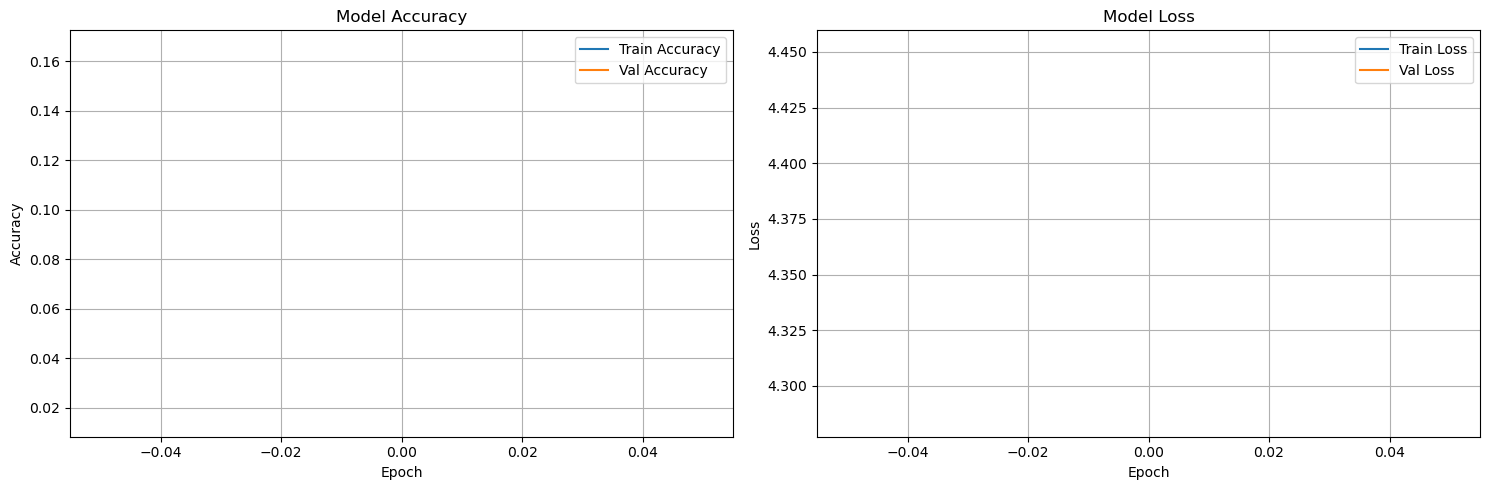

In [25]:

# ===================================================
# Start Here for Training
# ======================================================

# Device available for training
print(tf.config.list_physical_devices())
print("Available devices:", tf.config.list_physical_devices())
print("GPUs found:", len(tf.config.list_physical_devices('GPU')))
print("Final policy:", mixed_precision.global_policy())
# Setup
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
output_dir, folder_name = create_output_dir()
data_path = get_data_path()

model = None
history = None

# retreive configuration info
model_backbone='custom_cnn' # mobilenet | custom_cnn | efficientnet
config = ModelConfig(model_backbone) 
set_host_config_overides(config=config)

# Save config to file
config_path = os.path.join(output_dir, "config.json")
with open(config_path, "w") as f:
    json.dump(config.to_dict(), f, indent=2)
print(f"✅ Config saved to: {config_path}")

train_set, validation_set = create_data_generators(config, data_path)

# Train
if model_backbone=='custom_cnn':
    model,  history = train_model_cnn(config, train_set, validation_set)
else:
    model, history = train_model_mobilenet(config, train_set, validation_set)

# Plot training history
fig_hist = plot_training_history(history)
if fig_hist:
    fig_hist.show()
    #save_plot(fig_hist, "model history", output_dir)
    
save_model(model, 'emotion_recognition_ft', output_dir, folder_name) 

<h1> Reporting </h1>

In [26]:
# ===================================================
# Start Here for Reporting if retreiving from file
# ===================================================

# Run full evaluation
# Load model
# retreive configuration info

if 'model' not in globals():
    # reload model
    # don't resave plots
    save_outputs=True
    data_path = get_data_path()
    class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
    model_backbone='custom_cnn' # mobilenet | custom_cnn | efficientnet
    config = ModelConfig(model_backbone) 
    train_set, validation_set = create_data_generators(config, data_path)
    model_path_ft, output_dir = load_model_path()
    model= load_models_from_file(model_path_ft)
    print(f"\n Output Path={output_dir}")
    
# Run evaluation
evaluator = ModelEvaluator(model, validation_set, class_labels, output_dir, save_outputs=True)
predictions, true_labels = evaluator.generate_predictions()


🔄 Generating predictions...
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 258ms/step



💾 Plot saved: outputs\20251116_161212

💾 Plot saved: outputs\20251116_161212

💾 Plot saved: outputs\20251116_161212

📊 Classification Report:
              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00       960
     Disgust       0.02      1.00      0.03       111
        Fear       0.00      0.00      0.00      1018
       Happy       0.00      0.00      0.00      1825
     Neutral       0.00      0.00      0.00      1216
         Sad       0.00      0.00      0.00      1139
    Surprise       0.00      0.00      0.00       797

    accuracy                           0.02      7066
   macro avg       0.00      0.14      0.00      7066
weighted avg       0.00      0.02      0.00      7066



c:\Users\marty\anaconda3\envs\tf311_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\marty\anaconda3\envs\tf311_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\marty\anaconda3\envs\tf311_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 


💾 Plot saved: outputs\20251116_161212

💾 Plot saved: outputs\20251116_161212

💾 Plot saved: outputs\20251116_161212

💾 Plot saved: outputs\20251116_161212

🔍 Top 5 Misclassifications:
True: Angry → Pred: Disgust (Confidence: 34.38%)
True: Angry → Pred: Disgust (Confidence: 32.34%)
True: Angry → Pred: Disgust (Confidence: 33.50%)
True: Angry → Pred: Disgust (Confidence: 32.44%)
True: Angry → Pred: Disgust (Confidence: 34.33%)


c:\Users\marty\anaconda3\envs\tf311_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


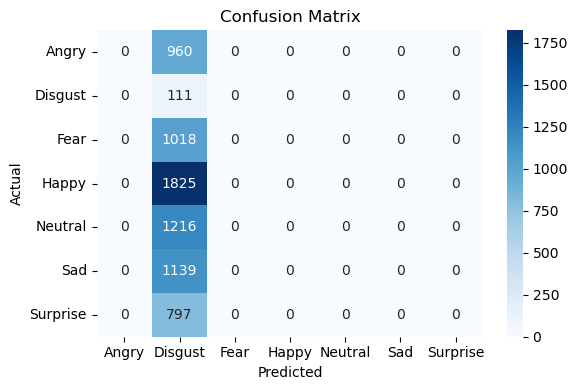

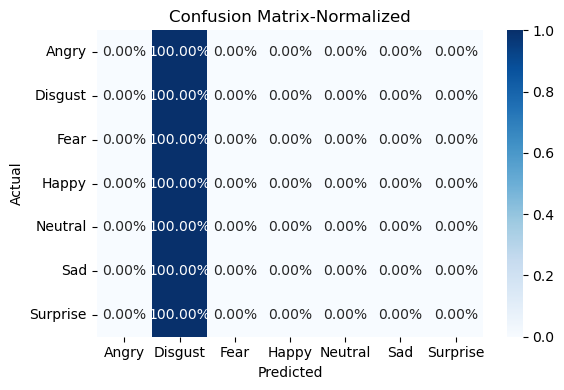

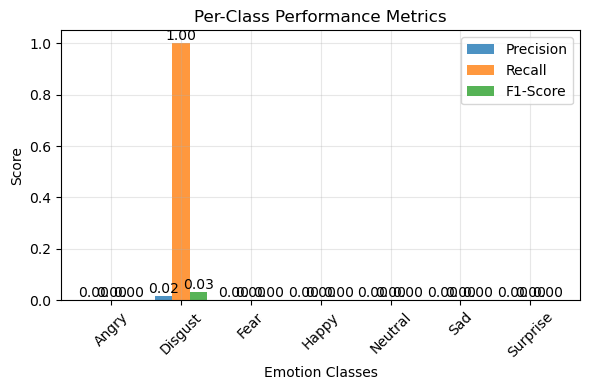

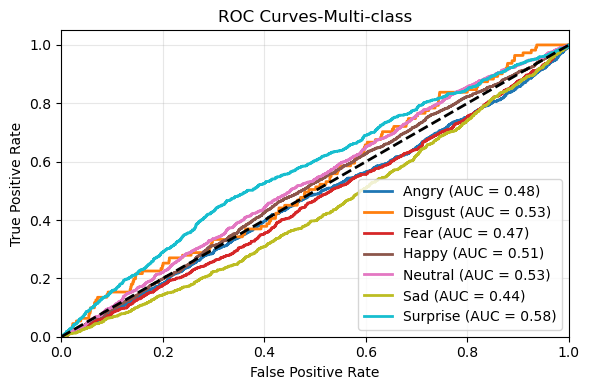

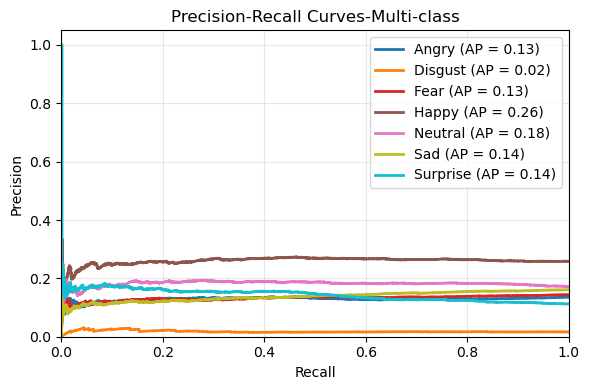

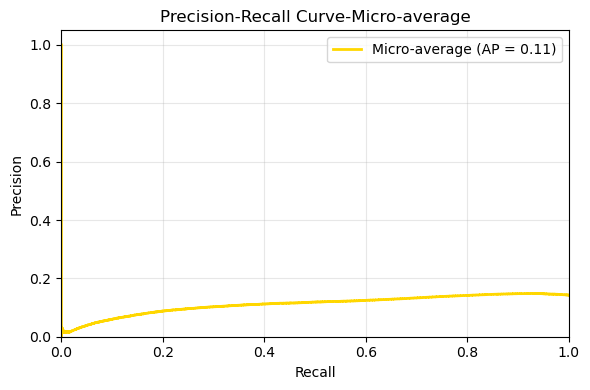

In [27]:

evaluator.create_comprehensive_report()


✅ Evaluation complete! Reports saved to: outputs/20251116_161212/


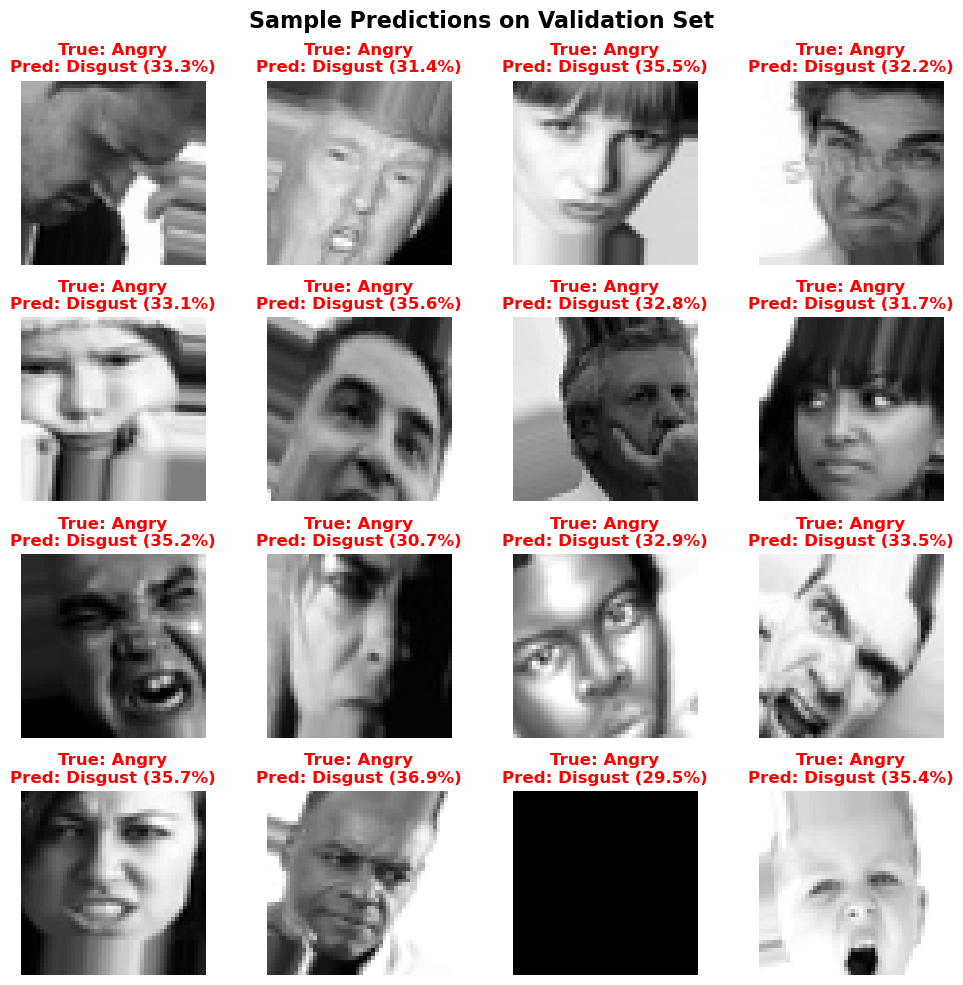

In [28]:
# Test 
random_predictions_plt = test_random_predictions(model, validation_set, class_labels)
print(f"✅ Evaluation complete! Reports saved to: {output_dir}")
random_predictions_plt.show()


In [ ]:
import shutil


folder_name = os.path.basename(os.path.normpath(output_dir))

shutil.make_archive(
    base_name=os.path.join(output_dir, folder_name),  # where to save: outputs/20251116_153821/20251116_153821
    format="zip",
    root_dir=output_dir,  # folder to zip
    base_dir="."          # zip everything inside root_dir
)

'c:\\Users\\marty\\OneDrive\\_TAFE\\Deeplearning\\Project\\outputs\\20251116_161212\\20251116_161212.zip'

In [32]:
#print("Global policy:", mixed_precision.global_policy())
#print("Model dtype policy:", model.dtype_policy)   # or model.input_dtype / model.output_dtype  

# ===================================================
# The end
# ===================================================